# Adjoint-based shape optimization of a waveguide bend

> Note: native autograd support is an experimental feature in tidy3d 2.7. To see the original implementation of this notebook using jax and the adjoint plugin, refer to [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin8WaveguideBend/).

In this notebook, we will apply the adjoint method to the optimization of a low-loss waveguide bend. We start with a 90 degree bend in a SiN waveguide, parameterized using a `td.PolySlab`. 

We define an objective function that seeks to maximize the transmission of the TE0 output mode amplitude with respect to the position of the polygon vertices defining the bend. A penalty is applied to keep the local radii of curvature larger than a pre-defined value.

The resulting device demonstrates low loss and exhibits a smooth geometry.

> To install the `autograd` package required for this feature, we recommend running `pip install autograd`.

<img src="img/adjoint_8.png" width=400 alt="Schematic of the waveguide bend">

If you are unfamiliar with inverse design, we also recommend our [intro to inverse design tutorials](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) and our [primer on automatic differentiation with tidy3d](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd1Intro/).

## Setup

First, we import `tidy3d`. We will also use `numpy`, `matplotlib` and `autograd`. 

In [1]:
import tidy3d as td
import tidy3d.web as web
import numpy as np
import matplotlib.pylab as plt
import autograd as ag
import autograd.numpy as anp

Next, we define all the global parameters for our device and optimization.

In [2]:
wavelength = 1.5
freq0 = td.C_0 / wavelength

# frequency of measurement and source
# note: we only optimize results at the central frequency for now.
fwidth = freq0 / 10
num_freqs = 1
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)
freqs = np.array([freq0])

# define the discretization of the bend polygon in angle
num_pts = 60
angles = np.linspace(0, np.pi / 2, num_pts + 2)[1:-1]

# refractive indices of waveguide and substrate (air above)
n_wg = 2.0
n_sub = 1.5

# min space between waveguide and PML
spc = 1 * wavelength

# length of input and output straight waveguide sections
t = 1 * wavelength

# distance between PML and the mode source / mode monitor
mode_spc = t / 2.0

# height of waveguide core
h = 0.7

# minimum, starting, and maximum allowed thicknesses for the bend geometry
wmin = 0.5
wmid = 1.5
wmax = 2.5

# average radius of curvature of the bend
radius = 6

# minimum allowed radius of curvature of the polygon
min_radius = 150e-3

# name of the monitor measuring the transmission amplitudes for optimization
monitor_name = "mode"

# how many grid points per wavelength in the waveguide core material
min_steps_per_wvl = 20

# how many mode outputs to measure
num_modes = 3
mode_spec = td.ModeSpec(num_modes=num_modes)

Using all of these parameters, we can define the total simulation size.

In [3]:
Lx = Ly = t + radius + abs(wmax - wmid) + spc
Lz = spc + h + spc

### Define parameterization

Next we describe how the geometry looks as a function of our design parameters.

At each angle on our bend discretization, we define a parameter that can range between `-inf` and `+inf` to control the thickness of that section. If that parameter is `-inf`, `0`, and `+inf`, the thickness of that section is `wmin`, `wmid`, and `wmax`, respectively.

This gives us a smooth way to constrain our measurable parameter without needing to worry about it in the optimization.

In [4]:
def thickness(param: float) -> float:
    """thickness of a bend section as a function of a parameter in (-inf, +inf)."""
    param_01 = (anp.tanh(param) + 1.0) / 2.0
    return wmax * param_01 + wmin * (1 - param_01)

Next we write a function to generate all of our bend polygon vertices given our array of design parameters. Note that we add extra vertices at the beginning and end of the bend that are **independent** of the parameters (static) and are only there to make it easier to connect the bend to the input and output waveguide sections.

In [5]:
def make_vertices(params: np.ndarray) -> list:
    """Make bend polygon vertices as a function of design parameters."""
    vertices = []
    vertices.append((-Lx / 2 + 1e-2, -Ly / 2 + t + radius))
    vertices.append((-Lx / 2 + t, -Ly / 2 + t + radius + wmid / 2))
    for angle, param in zip(angles, params):
        thickness_i = thickness(param)
        radius_i = radius + thickness_i / 2.0
        x = radius_i * np.sin(angle) - Lx / 2 + t
        y = radius_i * np.cos(angle) - Ly / 2 + t
        vertices.append((x, y))
    vertices.append((-Lx / 2 + t + radius + wmid / 2, -Ly / 2 + t))
    vertices.append((-Lx / 2 + t + radius, -Ly / 2 + 1e-2))
    vertices.append((-Lx / 2 + t + radius - wmid / 2, -Ly / 2 + t))
    for angle, param in zip(angles[::-1], params[::-1]):
        thickness_i = thickness(param)
        radius_i = radius - thickness_i / 2.0
        x = radius_i * np.sin(angle) - Lx / 2 + t
        y = radius_i * np.cos(angle) - Ly / 2 + t
        vertices.append((x, y))
    vertices.append((-Lx / 2 + t, -Ly / 2 + t + radius - wmid / 2))
    return vertices

Let's try out our `make_vertices` function on a set of all `0` parameters, which should give the starting waveguide width of `wmid` across the bend.

In [6]:
params = np.zeros(num_pts)
vertices = make_vertices(params)

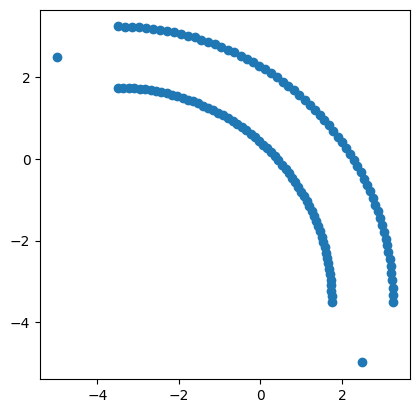

In [7]:
plt.scatter(*np.array(vertices).T)
ax = plt.gca()
ax.set_aspect("equal")

Looks good, note again that the extra points on the ends are just to ensure a solid overlap with the in and out waveguides. At this time, the autograd differentiation does not handle polygons that extend outside of the simulation domain so we need to also ensure that all points are inside of the domain.

In [8]:
def make_polyslab(params: np.ndarray) -> td.PolySlab:
    """Make a `tidy3d.PolySlab` for the bend given the design parameters."""
    vertices = make_vertices(params)
    return td.PolySlab(vertices=vertices, slab_bounds=(-h / 2, h / 2), axis=2)

Let's visualize this as well.

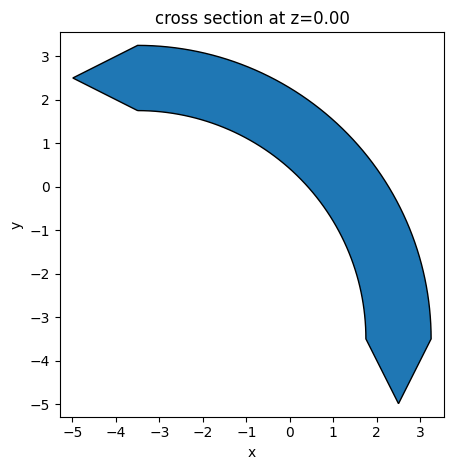

In [9]:
polyslab = make_polyslab(params)
ax = polyslab.plot(z=0)

Keeping with this theme, we add a function to generate the structure itself.

In [10]:
def make_structure(params) -> td.Structure:
    polyslab = make_polyslab(params)
    medium = td.Medium(permittivity=n_wg**2)
    return td.Structure(geometry=polyslab, medium=medium)

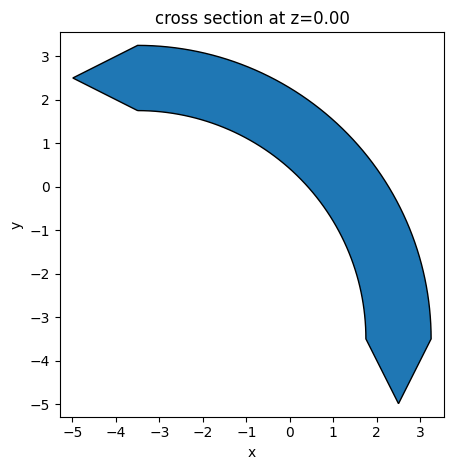

In [11]:
ring = make_structure(params)
ax = ring.plot(z=0)

Next, we define the other geometries, such as the input waveguide section, output waveguide section, and substrate.

In [12]:
box_in = td.Box.from_bounds(
    rmin=(-Lx / 2 - 1, -Ly / 2 + t + radius - wmid / 2, -h / 2),
    rmax=(-Lx / 2 + t + 1e-3, -Ly / 2 + t + radius + wmid / 2, +h / 2),
)
box_out = td.Box.from_bounds(
    rmin=(-Lx / 2 + t + radius - wmid / 2, -Ly / 2 - 1, -h / 2),
    rmax=(-Lx / 2 + t + radius + wmid / 2, -Ly / 2 + t, +h / 2),
)

geo_sub = td.Box.from_bounds(
    rmin=(-td.inf, -td.inf, -10000),
    rmax=(+td.inf, +td.inf, -h / 2),
)

wg_in = td.Structure(geometry=box_in, medium=td.Medium(permittivity=n_wg**2))
wg_out = td.Structure(geometry=box_out, medium=td.Medium(permittivity=n_wg**2))
substrate = td.Structure(geometry=geo_sub, medium=td.Medium(permittivity=n_sub**2))

## Fabrication Constraints

With the current parameterization, it is possible to generate structures with wildly varying radii of curvature which may be difficult to fabricate. To alleviate this, we introduce a minimum radius of curvature penalty transformation using the tidy3d `autograd` utilities. The penalty will take a set of vertices, compute the local radius of curvature using a quadratic Bezier curve, and return an average penalty function that depends on how much smaller the local radii are compared to a desired minimum radius.

In [13]:
from tidy3d.plugins.autograd.invdes import make_curvature_penalty

penalty = make_curvature_penalty(min_radius)

We then wrap this penalty to look at only the inner and outer vertices independently and average the penalty from each.

In [14]:
def eval_penalty(params):
    """Evaluate penalty on a set of params looking at radius of curvature."""
    vertices = make_vertices(params)
    _vertices = anp.array(vertices)
    vertices_top = _vertices[1 : num_pts + 3]  # select outer set of points along bend
    vertices_bot = _vertices[num_pts + 4 :]  # select inner set of points along bend
    penalty_top = penalty(vertices_top)
    penalty_bot = penalty(vertices_bot)
    return (penalty_top + penalty_bot) / 2.0

Let's try this out on our starting parameters. We see we get an autograd traced float that seems reasonably low given our smooth starting structure.

In [15]:
eval_penalty(params)

3.57973410373255e-23

## Define Simulation

Now we define our sources, monitors, and simulation.

We first define a mode source injected at the input waveguide.

In [16]:
mode_width = wmid + 2 * spc
mode_height = Lz

mode_src = td.ModeSource(
    size=(0, mode_width, mode_height),
    center=(-Lx / 2 + t / 2, -Ly / 2 + t + radius, 0),
    direction="+",
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth,
    ),
)

Next, we define monitors for storing:

- The output mode amplitude at the central frequency.

- The flux on the output plane (for reference).

- The output mode amplitude across a frequency range (for examining the transmission spectrum of our final device).

- A field monitor to measure fields directly in the z-normal plane intersecting the waveguide.

In [17]:
mode_mnt = td.ModeMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx / 2 + t + radius, -Ly / 2 + t / 2, 0),
    name=monitor_name,
    freqs=[freq0],
    mode_spec=mode_spec,
)

flux_mnt = td.FluxMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx / 2 + t + radius, -Ly / 2 + t / 2, 0),
    name="flux",
    freqs=[freq0],
)

mode_mnt_bb = td.ModeMonitor(
    size=(mode_width, 0, mode_height),
    center=(-Lx / 2 + t + radius, -Ly / 2 + t / 2, 0),
    name="mode_bb",
    freqs=freqs.tolist(),
    mode_spec=mode_spec,
)

fld_mnt = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

Next we put everything together into a function that returns a `td.Simulation` given our parameters and an optional boolean specifying whether to include the field monitor (to save data when fields are not required).

In [18]:
def make_sim(params, use_fld_mnt: bool = True) -> td.Simulation:
    monitors = [mode_mnt_bb, flux_mnt]
    if use_fld_mnt:
        monitors += [fld_mnt]
    ring = make_structure(params)
    return td.Simulation(
        size=(Lx, Ly, Lz),
        structures=[substrate, wg_in, wg_out, ring],
        sources=[mode_src],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=True),
        monitors=monitors + [mode_mnt],
        run_time=10 / fwidth,
    )

Let's try it out and plot our simulation.

16:58:51 EDT WARNING: Structure at structures[3] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 1 WARNING message.                             

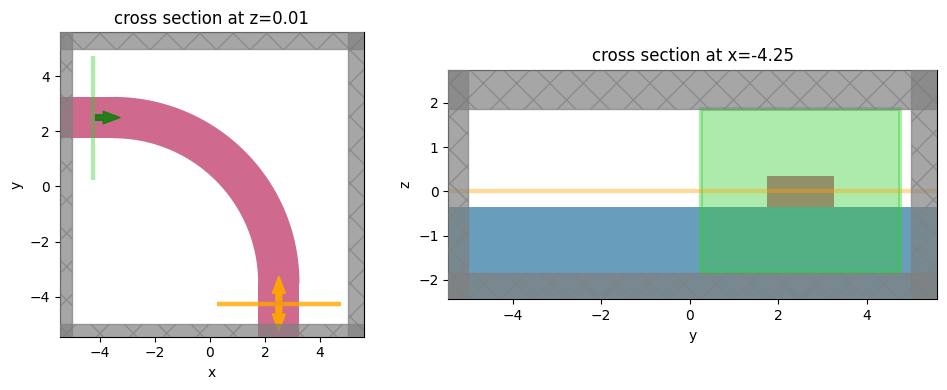

In [19]:
sim = make_sim(params)

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
ax = sim.plot(z=0.01, ax=ax1)
ax = sim.plot(x=-Lx / 2 + t / 2, ax=ax2)

In [20]:
# let's turn off warnings because we know this ring is intersecting with our waveguide ports.
td.config.logging_level = "ERROR"

## Select the desired waveguide mode

Next, we use the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) to solve and select the `mode_index` that gives us the proper injected and measured modes. We plot all of the fields for the first 3 modes and see that the TE0 mode is `mode_index=0`.

Effective index of computed modes:  [[1.7968912 1.7528987 1.6045505]]


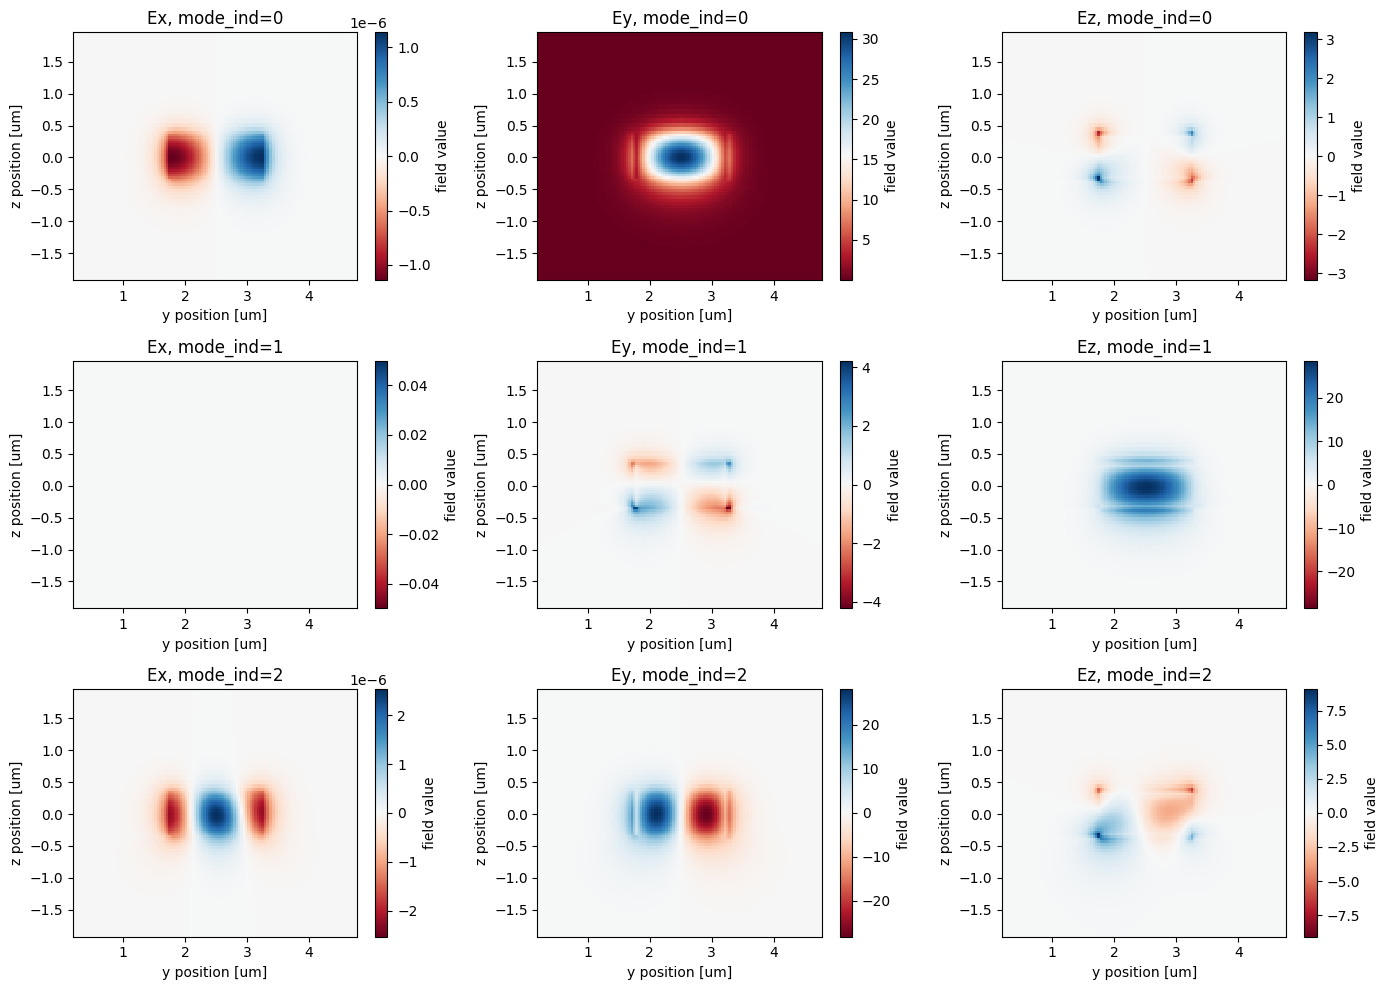

In [21]:
from tidy3d.plugins.mode import ModeSolver

ms = ModeSolver(simulation=sim, plane=mode_src, mode_spec=mode_spec, freqs=mode_mnt.freqs)
data = ms.solve()

print("Effective index of computed modes: ", np.array(data.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(14, 10), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = data.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(x="y", y="z", ax=ax, cmap="RdBu")
        ax.set_title(f"{field_name}, mode_ind={mode_ind}")

Since this is already the default mode index, we can leave the original `make_sim()` function as is. However, to generate a new mode source with a different `mode_index`, we could do the following and rewrite that function with the returned `mode_src`.

In [22]:
# select the mode index
mode_index = 0

# make the mode source with appropriate mode index
mode_src = ms.to_source(
    mode_index=mode_index, source_time=mode_src.source_time, direction=mode_src.direction
)

## Defining objective function

Now we can define our objective function to maximize. The objective function first generates a simulation given the parameters, runs the simulation using the builtin `web.run()` function, measures the power transmitted into the TE0 output mode at our desired polarization, and then subtracts the radius of curvature penalty that we defined earlier.

In [23]:
def objective(params: np.ndarray, use_fld_mnt: bool = True) -> float:
    sim = make_sim(params, use_fld_mnt=use_fld_mnt)
    sim_data = web.run(sim, task_name="bend", verbose=False)

    # be sure to take .values here before summing the transmission
    amps = sim_data[monitor_name].amps.sel(direction="-", mode_index=mode_index).values

    transmission = anp.abs(anp.array(amps)) ** 2
    J = anp.sum(transmission) - eval_penalty(params)
    return J

Next, we use [autograd.value_and_grad](https://ag.readthedocs.io/en/latest/_autosummary/ag.value_and_grad.html) to transform this objective function into a function that returns the 

* Objective function evaluated at the passed parameters.

* Gradient of the objective function with respect to the passed parameters.

In [24]:
val_grad = ag.value_and_grad(objective)

Let's run this function and take a look at the outputs.

In [25]:
val, grad = val_grad(params)

In [26]:
print(val)
print(grad)

0.5687328958995664
[ 0.01048215  0.01440584  0.01111879  0.00474245 -0.00762292 -0.01405522
 -0.01299603 -0.03174106 -0.05005555 -0.0642159  -0.10065141 -0.11588894
 -0.11589821 -0.10702039 -0.0902824  -0.08552544 -0.0641153  -0.03367122
 -0.00274959  0.02581574  0.06161947  0.0943915   0.11971836  0.14512055
  0.16603845  0.19672021  0.22781623  0.24837481  0.24612261  0.24857196
  0.26118485  0.2730175   0.28623967  0.27754263  0.24272923  0.1996468
  0.16707709  0.14104666  0.10331249  0.04774821 -0.00602223 -0.05919282
 -0.11039988 -0.16400582 -0.22962657 -0.28574998 -0.30274091 -0.33806615
 -0.3584718  -0.34085411 -0.35737706 -0.36945383 -0.34688175 -0.29722984
 -0.25217348 -0.23155299 -0.19480561 -0.14791433 -0.11364646 -0.07770037]


These seem reasonable and can now be used for plugging into our optimization algorithm.

## Optimization Procedure

With our gradients defined, we write a simple optimization loop using the [optax](https://optax.readthedocs.io/en/latest/) package. We use the `adam` method with a tunable number of steps and learning rate. The intermediate values, parameters, and data are stored for visualization later.

> Note: this will take several minutes. While not shown here, it is good practice to checkpoint your optimization results by saving to file on every iteration, or ensure you have a stable internet connection. See [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) for more details. 

In [27]:
import optax

# hyperparameters
num_steps = 15
learning_rate = 0.05

# initialize adam optimizer with starting parameters
params = np.array(params).copy()
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
objective_history = []
param_history = [params]
data_history = []

for i in range(num_steps):
    # compute gradient and current objective funciton value
    value, gradient = val_grad(params)

    # multiply all by -1 to maximize obj_fn
    gradient = -np.array(gradient)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # it is important using optax to convert the parameters back to numpy arrays to feed back to our gradient
    params = np.array(params)

    # save history
    objective_history.append(value)
    param_history.append(params)


step = 1
	J = 5.6873e-01
	grad_norm = 1.4787e+00
step = 2
	J = 7.2474e-01
	grad_norm = 1.3420e+00
step = 3
	J = 8.4718e-01
	grad_norm = 9.8658e-01
step = 4
	J = 9.1464e-01
	grad_norm = 6.8390e-01
step = 5
	J = 9.3531e-01
	grad_norm = 4.4853e-01
step = 6
	J = 9.1917e-01
	grad_norm = 5.8707e-01
step = 7
	J = 8.9048e-01
	grad_norm = 7.6125e-01
step = 8
	J = 8.6774e-01
	grad_norm = 8.6826e-01
step = 9
	J = 8.5773e-01
	grad_norm = 9.0074e-01
step = 10
	J = 8.5703e-01
	grad_norm = 8.4340e-01
step = 11
	J = 8.6281e-01
	grad_norm = 7.5339e-01
step = 12
	J = 8.6980e-01
	grad_norm = 6.3775e-01
step = 13
	J = 8.7591e-01
	grad_norm = 5.2366e-01
step = 14
	J = 8.8279e-01
	grad_norm = 4.0568e-01
step = 15
	J = 8.8637e-01
	grad_norm = 3.7248e-01


## Analyzing results

After the optimization is finished, let's look at the results.

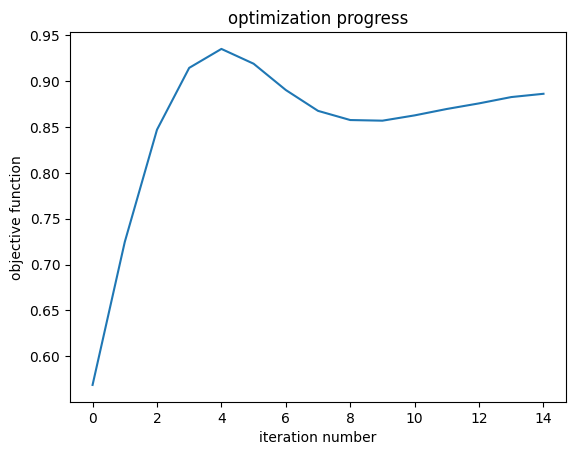

In [28]:
_ = plt.plot(objective_history)
ax = plt.gca()
ax.set_xlabel("iteration number")
ax.set_ylabel("objective function")
ax.set_title("optimization progress")
plt.show()

Next, we can grab our initial and final device from the history lists.

In [29]:
import tidy3d.web as web

sim_start = make_sim(param_history[0])
data_start = web.run(sim_start, task_name="start")

sim_final = make_sim(param_history[-1])
data_final = web.run(sim_final, task_name="final")

↓ simulation_data.hdf5.gz ━━━━━━━━━━━━ 100.0% • 3.6/3.6 MB • 10.0 MB/s • 0:00:00

17:54:02 EDT loading simulation from simulation_data.hdf5

Let's take a look at the final structure. We see that it has a smooth design which is symmetric about the 45 degree angle.

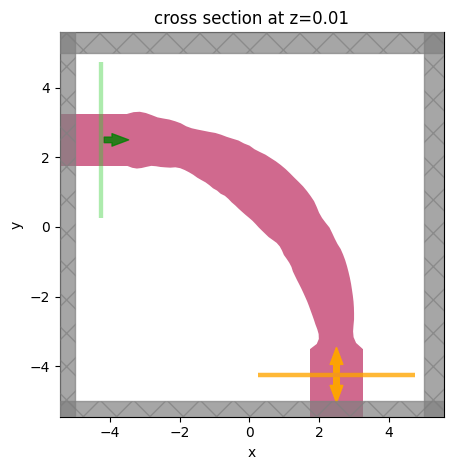

In [30]:
ax = sim_final.plot(z=0.01)

Now let's inspect the difference between the initial and final intensity patterns. We notice that the final device is quite effective at coupling light into the output waveguide! This is especially evident when compared to the starting device.

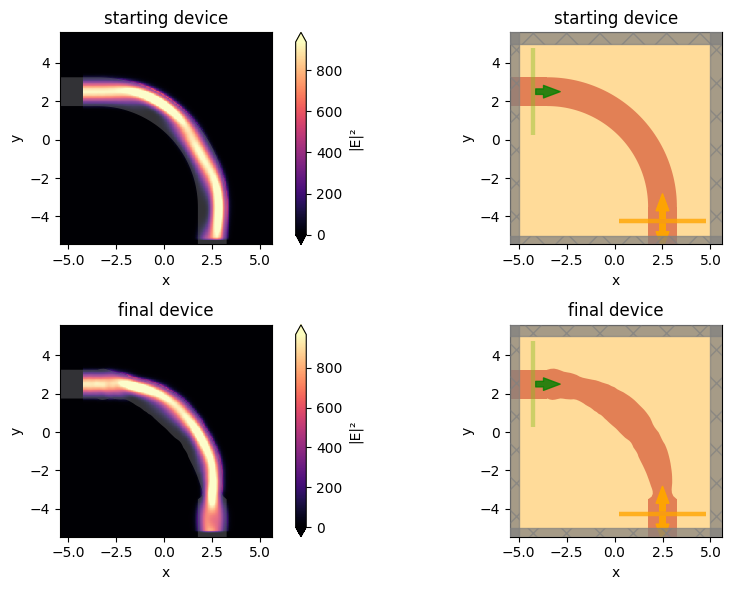

In [31]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout=True, figsize=(10, 6))

_ = data_start.plot_field("field", "E", "abs^2", ax=ax1)
_ = sim_start.plot(z=0, ax=ax2)
ax1.set_title("starting device")
ax2.set_title("starting device")

_ = data_final.plot_field("field", "E", "abs^2", ax=ax3)
_ = sim_final.plot(z=0, ax=ax4)
ax3.set_title("final device")
ax4.set_title("final device")

plt.show()

Let's view the transmission now, both in linear and dB scale.

The mode amplitudes are simply an [xarray.DataArray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html) that can be selected, post processed, and plotted.

In [32]:
amps = data_final["mode_bb"].amps.sel(direction="-", mode_index=mode_index)

In [33]:
transmission = abs(amps) ** 2
transmission_percent = 100 * transmission

print(f'transmission of {transmission_percent.values[0]:.3f} %')

transmission of 89.229 %


## Export to GDS
The `Simulation` object has the [.to_gds_file](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.to_gds_file) convenience function to export the final design to a `GDS` file. In addition to a file name, it is necessary to set a cross-sectional plane (`z = 0` in this case) on which to evaluate the geometry. See the [GDS export](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSExport/) notebook for a detailed example on using `.to_gds_file` and other GDS related functions.

In [34]:
sim_final.to_gds_file(
    fname="./misc/inverse_des_wg_bend.gds",
    z=0,
)